# 1. Raw data preprocessing and dF/F0 calculation
For an individual session.

You will need to have behavior_base.py, behavioral_albert_MKedits.py, and behavioral_pipeline.py saved locally to run this notebook. These scripts are available on Hongli's github.

In [1]:
import h5py
import numpy as np
import os
from behavior_base import *
from behavioral_albert_MKedits import *
from behavioral_pipeline import *

In [21]:
# Specify session to analyze
animal = 'JUV021'
session = '230131'
input_folder = fr"\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\processed_data\Data\{animal}\{session}"

# Load Suite2P files
Fraw = np.load(input_folder + "\suite2p\plane0\F.npy")
ops = np.load(input_folder + "\suite2p\plane0\ops.npy",allow_pickle=True)
neuropil = np.load(input_folder + "\suite2p\plane0\Fneu.npy")
cells = np.load(input_folder + "\suite2p\plane0\iscell.npy")
stat = np.load(input_folder + "\suite2p\plane0\stat.npy",allow_pickle=True)
iscell = np.load(input_folder + "\suite2p\plane0\iscell.npy")

In some cases, frames at the end of a session are unusable (i.e., files are corrupt, or matlab crashed while imaging was still going on). In this case, we don't want to analyze those frames, so we can manually cut off the end frames below.

If you don't need to do that, MAKE SURE YOU DON'T RUN THE CELL BELOW!

Note: the edited files will save to the directory of this notebook, and you will have to copy them to the correct folder. Feel free to edit this code to specify that folder. You will then have to re-load the files in this notebook to proceed (you can re-run the cell above)

In [23]:
# Remove unusable frames at end of image series, if applicable
# Most of my time series have 28987 frames: 8.052 Hz x 3600 sec
actual_frames = 28900 # number of frames to keep
newF = []
newpil = []
for cell in range(0,len(Fraw)):
    newF.append(Fraw[cell][:actual_frames])
    newpil.append(neuropil[cell][:actual_frames])


np.save('F',newF)
np.save('Fneu',newpil)

Here we subtract neuropil (a coefficient of 0.7 is standard but you can change it), create a new matrix containing only ROIs that are cells, establish their F0, and then calculate dFF.

Note: this function is already incorporated into the pipeline used for aligning behavior and imaging data in the "FullCa2Pipeline_HongliEdits" notebook.

In [3]:
def preprocess(Fnpy, Fneu, cells):
    F = Fnpy - Fneu*0.7 # subtract neuropil

    # find number of cells
    numcells = 0
    for cell in range(0,len(cells)):
        if cells[cell,0] == 1.0: # if ROI is a cell
            numcells += 1

    Fcells = np.zeros((numcells,F.shape[1])) # create new F matrix with only data from ROIs that are cells
    counter = 0
    for cell in range(0,len(cells)):
        if cells[cell,0] == 1.0: # if ROI is a cell
            Fcells[counter] = F[cell]
            counter += 1
            
    F0_AQ = np.zeros(Fcells.shape) # determine F0 using Albert's method
    for cell in range(Fcells.shape[0]):
        F0_AQ[cell] = robust_filter(Fcells[cell], method=12, window=200, optimize_window=2, buffer=False)[:, 0]

    dFF = np.zeros(Fcells.shape) # calculate dF/F0
    for cell in range(0,Fcells.shape[0]):
        for frame in range(0,Fcells.shape[1]):
            dFF[cell, frame] = (Fcells[cell, frame] - F0_AQ[cell, frame]) / F0_AQ[cell, frame]
    return dFF

In [ ]:
dFF = preprocess(Fraw, neuropil, iscell)

# 2. Sort cells by dF/F0 activity and plot traces

In [104]:
# calculate average fluorescence of each neuron
activity = []
for neuron in range(0,dFF.shape[0]):
    avg = np.mean(dFF[neuron])
    activity.append(avg)

In [112]:
# sort cells by activity level
most_active = []
least_active = []
mid_active = []
percentile90 = []
percentile80 = []
percentile70 = []
percentile60 = []
percentile50 = []
percentile40 = []
percentile30 = []
percentile20 = []
percentile10 = []
percentile00 = []
for neuron in range(0,len(activity)):
    if activity[neuron] > np.quantile(activity,0.90):
        percentile90.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.80):
        percentile80.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.70):
        percentile70.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.60):
        percentile60.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.50):
        percentile50.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.40):
        percentile40.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.30):
        percentile30.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.20):
        percentile20.append(neuron)
    elif activity[neuron] > np.quantile(activity,0.10):
        percentile10.append(neuron)
    elif activity[neuron] < np.quantile(activity,0.10):
        percentile00.append(neuron) 

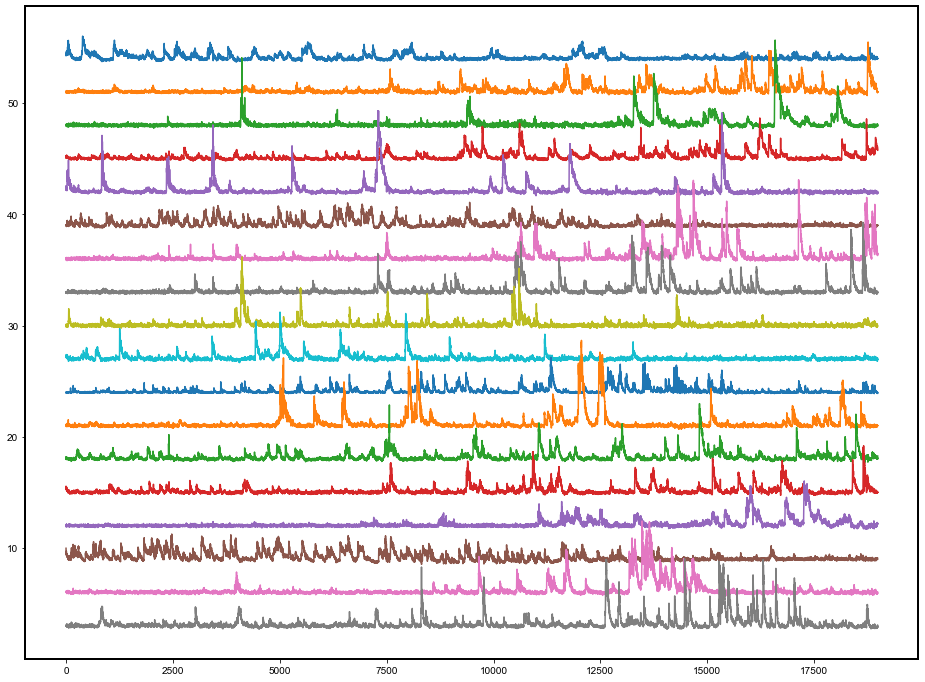

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,12))
counter = len(percentile80)
#colors = plt.cm.brg(np.linspace(0,0.5,30))
for neuron in percentile80:
    plt.plot(dFF[neuron,10000:] + (3*counter), lw=1.5) #color=colors[counter], lw=1.5)
    counter -= 1

# 3. Plot imaging locations

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [13]:
# I manually copied the FOV coordinates from my "Animal Training Log" notes into a spreadsheet
early = pd.read_csv ('ImagingLocations_Early.csv')
late = pd.read_csv ('ImagingLocations_Late.csv')
early['A/P'] = early['A/P'].abs()
late['A/P'] = late['A/P'].abs()
JUV_early = early[early['Animal'].str.contains('JUV', regex=False)]
ADT_early = early[early['Animal'].str.contains('ADT', regex=False)] 
JUV_late = late[late['Animal'].str.contains('JUV', regex=False)]
ADT_late = late[late['Animal'].str.contains('ADT', regex=False)] 

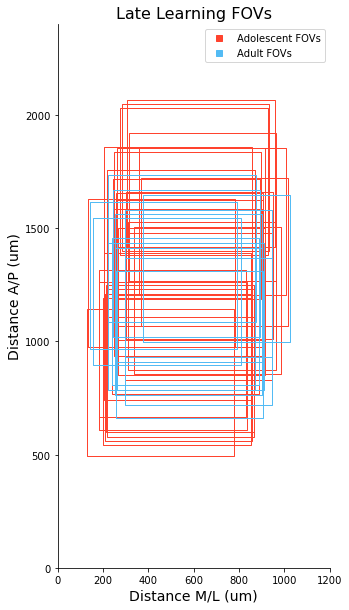

In [14]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.set_xlim(0,1200)
ax.set_ylim(0,2400) # x and y are flipped in manuscript figure
ax.set_aspect('equal')
ax.apply_aspect()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plotwidth=ax.get_position().transformed(fig.transFigure).width*72/fig.dpi
markerwidth=plotwidth*(650/1200) # width of imaging FOV / width of figure plot as specified in ax.set_xlim
ax.scatter(JUV_late['M/L'], JUV_late['A/P'], marker='s', facecolors='none', edgecolors='#FF432E', s=markerwidth**2)
ax.scatter(ADT_late['M/L'], ADT_late['A/P'], marker='s', facecolors='none', edgecolors='#53BBF4', s=markerwidth**2)
JUV = mlines.Line2D([], [], color='#FF432E', marker='s', ls='', label='Adolescent FOVs')
ADT = mlines.Line2D([], [], color='#53BBF4', marker='s', ls='', label='Adult FOVs')
# colors in manuscript are JUV = #FA7F6F and ADT = #82B0D2
plt.legend(handles=[JUV, ADT])
plt.xlabel('Distance M/L (um)', fontsize=14)
plt.ylabel('Distance A/P (um)', fontsize=14)
plt.title('Late Learning FOVs', fontsize=16)
plt.show()

# 4. Activity by session
Calculate mean integrated dF/F0 and average cell count per age group

In [2]:
import h5py
import numpy as np
import os
import pandas as pd
from ast import literal_eval

In [20]:
# Specify animals to analyze, then find the number of cells and mean integrated dF/F0 per session
# this generates a list of lists, where each sublist corresponds to one animal
learners = ['ADT008', 'ADT009', 'ADT010', 'ADT027', 'ADT028', 'ADT029',
           'JUV014', 'JUV015', 'JUV016', 'JUV017', 'JUV022', 'JUV024', 'JUV025']
exp_folder = r"\\filenest.diskstation.me\Wilbrecht_file_server\HongliWang\Madeline\LateLearning\Data"
ADT_cells = []
JUV_cells = [] 
ADT_dFF = []
JUV_dFF = []
# use "learners" to loop through ALL sessions from each animal
# use "exp_folder" to loop through only late learning sessions
# or specify another path
for animal in learners: #exp_folder:
    animal_path = fr"\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\processed_data\Data\{animal}"
    cells = []
    dFFint = []
    for session in os.listdir(animal_path):
        session_path = os.path.join(animal_path,session)
        if os.path.isfile(os.path.join(session_path,fr'{animal}_{session}_fluor.csv')):
            print (animal, session)
            dFF = pd.read_csv(fr"{session_path}\{animal}_{session}_fluor.csv")
            dFF = dFF.drop('Unnamed: 0', axis = 1)
            dFF = dFF.drop('time', axis = 1)
            cells.append(dFF.shape[1])
            dFFint.append(np.mean(np.sum(dFF))) # values used in Fig. 2C-E
        else:
            cells.append(np.nan)
            dFFint.append(np.nan)
    if 'ADT' in animal:
        ADT_cells.append(cells)
        ADT_dFF.append(dFFint)
    elif 'JUV' in animal:
        JUV_cells.append(cells)
        JUV_dFF.append(dFFint)

ADT008 220408
ADT008 220409
ADT008 220411
ADT008 220412
ADT008 220413
ADT008 220414
ADT008 220415
ADT008 220416
ADT008 220417
ADT008 220418
ADT008 220419
ADT008 220420
ADT008 220422
ADT009 220408
ADT009 220410
ADT009 220411
ADT009 220412
ADT009 220413
ADT009 220414
ADT009 220415
ADT009 220416
ADT009 220417
ADT010 220409
ADT010 220410
ADT010 220411
ADT010 220412
ADT010 220413
ADT010 220414
ADT010 220415
ADT010 220416
ADT027 231204
ADT027 231205
ADT027 231206
ADT027 231207
ADT027 231208
ADT027 231209
ADT028 231204
ADT028 231205
ADT028 231206
ADT028 231207
ADT028 231208
ADT028 231209
ADT028 231210
ADT028 231211
ADT028 231212
ADT028 231213
ADT029 231206
ADT029 231209
ADT029 231210
ADT029 231211
ADT029 231213
ADT029 231215
JUV014 220325
JUV014 220326
JUV014 220327
JUV014 220328
JUV014 220329
JUV014 220330
JUV014 220331
JUV014 220402
JUV014 220403
JUV014 220404
JUV014 220405
JUV014 220406
JUV014 220407
JUV014 220408
JUV015 220330
JUV015 220331
JUV015 220401
JUV015 220402
JUV015 220403
JUV015

Below, we can print out each list of lists to see the mean integrated dF/F0 for each animal, for each session. The cell block above prints out each animal and session as it loops through, which allows us to keep track of which session is which. This "list of lists" format is helpful for copying & pasting into Prism or for other data organization.

In [ ]:
print(ADT_dFF)
print(JUV_dFF)

If we want to look at averages across multiple animals, it's helpful to concatenate our list of lists and remove nans so we can perform additional calculations:

In [26]:
# concatenate all animals into one master list and remove nans
ADTdff_list = [session for animal in ADT_dFF for session in animal]
JUVdff_list = [session for animal in JUV_dFF for session in animal]
ADTcells_list = [session for animal in ADT_cells for session in animal]
JUVcells_list = [session for animal in JUV_cells for session in animal]
ADTdff_list = [x for x in ADTdff_list if not np.isnan(x)]
JUVdff_list = [x for x in JUVdff_list if not np.isnan(x)]
ADTcells_list = [x for x in ADTcells_list if not np.isnan(x)]
JUVcells_list = [x for x in JUVcells_list if not np.isnan(x)]

In [ ]:
# calculate mean and SEM of cells per age group
import scipy.stats
print(np.mean(ADTcells_list))
print(scipy.stats.sem(ADTcells_list))
print(np.mean(JUVcells_list))
print(scipy.stats.sem(JUVcells_list))

Using these two formats - both the list of lists, and the master list - you can add whatever other analyses you'd like!